In [15]:
#Import Statements

#basic
import pandas as pd
import numpy as np
from math import log,exp
import math

#visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn

% pylab inline

#sklearn
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix,accuracy_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor



#other stats
from scipy import stats
from patsy import dmatrices

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
C:\Users\Nicole\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Nicole\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Pre-processing

In [7]:
def preprocess(df):
    
    # Feature engineering for categorical variables captured as numbers
    # Turn MSSubClass into factors
    code = ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '150', '160', '180', '190']
    strings = ['1-STORY 1946 & NEWER ALL STYLES', '1-STORY 1945 & OLDER', '1-STORY W/FINISHED ATTIC ALL AGES', '1-1/2 STORY - UNFINISHED ALL AGES',\
     '1-1/2 STORY FINISHED ALL AGES', '2-STORY 1946 & NEWER', '2-STORY 1945 & OLDER', '2-1/2 STORY ALL AGES', \
     'SPLIT OR MULTI-LEVEL', 'SPLIT FOYER', 'DUPLEX - ALL STYLES AND AGES', '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',\
     '1-1/2 STORY PUD - ALL AGES', '2-STORY PUD - 1946 & NEWER', 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', \
     '2 FAMILY CONVERSION - ALL STYLES AND AGES']

    MSSubClass=dict(zip(code,strings))
    df['MSSubClass']=[MSSubClass[str(val)] for val in df['MSSubClass']]

    # Turn month sold into factors
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
    df['MoSold'] = df['MoSold'].replace(to_replace = df['MoSold'].value_counts().index.sort_values(),value=months)
    
    # Feature engineering for age-related variables
    # Convert yearsold vs yearbuilt into age of house
    df['Age'] =  df['YrSold'] - df['YearBuilt']
    df = df.drop('YearBuilt', 1)
    # Convert yearsold vs. yearreomdadd into age of remodel. Adding 2 to eliminate any negative or 0 values
    df['AgeRem'] = (df['YrSold'] - df['YearRemodAdd'])+2
    df = df.drop('YearRemodAdd', 1)
    # Remove age of garage - many missing values (if no garage)
    #  no additional valuable information (garage captured in other variables); age of house more important for age
    df = df.drop('GarageYrBlt', 1)
    df = df.drop('Id',1)
    
    # Fill select variables with most common / mode where logical
    # Most masonry veneer type is None and area is 0
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0.0)
    # Most electrical is 'SBrkr'
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    df['LotFrontage'] = df['LotFrontage'].fillna(mean(df['LotFrontage']))
    
    return df

In [3]:
def get_dummies(X_df):
    # Dummify X data
    X_dummy = pd.get_dummies(X_df,dummy_na=True)
    return X_dummy

In [4]:
def level_cat(df_train,df_comp):
    traincols = list(df_train.columns.values)
    testcols = list(df_comp.columns.values)
    
    # Align train data columns to competition data columns
    missingcols1 = list(set(testcols)-set(traincols))
    for col in missingcols1:
        df_train[col] = 0.0

    # Align test data columns to competition data columns
    missingcols = list(set(traincols)-set(testcols))
    for col in missingcols:
        df_comp[col] = 0.0
    df_comp = df_comp[traincols+missingcols1]
    
    return df_train,df_comp

In [8]:
housedata = preprocess(pd.read_csv('train.csv'))
# Split into X and y
y = housedata['SalePrice']
X = housedata.drop('SalePrice', 1)

#preprocess and dummify competition
X = get_dummies(X)
competition = preprocess(pd.read_csv('test.csv'))
X_comp = get_dummies(competition)

X,X_comp = level_cat(X,X_comp)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=1)

## Initial Model Exploration
Work that was done in APM HW 3

In [75]:
# Run models
#Linear Regression
MLR =LinearRegression()
model_MLR = MLR.fit(X_train,y_train)
MLR_predict = model_MLR.predict(X_test)
MLR_RMSE= sqrt(mean_squared_error(y_test, MLR_predict))
print "MLR RMSE:",MLR_RMSE

#get best λ with LassoCV
lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv = lasso_cv.fit(X_train,ravel(y_train))
print "Lasso CV best λ:",model_cv.alpha_
lasso_predict= model_cv.predict(X_test)
lasso_RMSE= sqrt(mean_squared_error(y_test, lasso_predict))
print "Lasso RMSE:",lasso_RMSE

#get best λ with RidgeCV
ridge_cv = RidgeCV(cv=10)
ridge_model_cv = ridge_cv.fit(X_train,ravel(y_train))
print "Ridge CV best λ:",ridge_model_cv.alpha_
ridge_predict= ridge_model_cv.predict(X_test)
ridge_RMSE= sqrt(mean_squared_error(y_test, ridge_predict))
print "Ridge RMSE:",ridge_RMSE

MLR RMSE: 35113.8209278
Lasso CV best λ: 224475.036998
Lasso RMSE: 39996.0347001
Ridge CV best λ: 10.0
Ridge RMSE: 29851.4865885


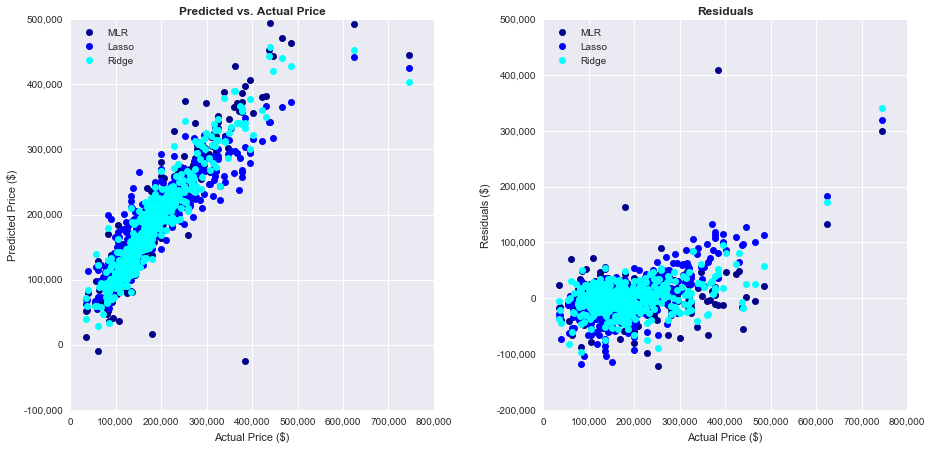

In [76]:
#Model residuals

MLRresiduals = y_test - MLR_predict
lassoResiduals = y_test - lasso_predict
ridgeResiduals = y_test - ridge_predict

# Plot residuals
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,MLR_predict,"o",label='MLR', color='darkblue')
ax1.plot(y_test,lasso_predict,"o",label='Lasso',color='blue')
ax1.plot(y_test,ridge_predict,"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLRresiduals,"o",label='MLR',color='darkblue')
ax2.plot(y_test,lassoResiduals,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [77]:
# Try predicting using log SalePrice
log_y_train = y_train.map(float).map(log)
log_y_test = y_test.map(float).map(log)

#Linear Regression
MLR =LinearRegression()
model_MLR2 = MLR.fit(X_train,log_y_train)
MLR_predict2 = model_MLR2.predict(X_test)
MLR_RMSE2 = sqrt(mean_squared_error(y_test, np.exp(MLR_predict2)))
print "MLR RMSE:",MLR_RMSE2

#get best λ with LassoCV
lasso_cv2 = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv2 = lasso_cv2.fit(X_train,ravel(log_y_train))
print "Lasso CV best λ:",model_cv2.alpha_
lasso_predict2= model_cv2.predict(X_test)
lasso_RMSE2 = sqrt(mean_squared_error(y_test, np.exp(lasso_predict2)))
print "Lasso RMSE:",lasso_RMSE2

#get best λ with RidgeCV
ridge_cv2 = RidgeCV(cv=10)
ridge_model_cv2 = ridge_cv2.fit(X_train,ravel(log_y_train))
print "Ridge CV best λ:",ridge_model_cv2.alpha_
ridge_predict2 = ridge_model_cv2.predict(X_test)
ridge_RMSE2 = sqrt(mean_squared_error(y_test, np.exp(ridge_predict2)))
print "Ridge RMSE:",ridge_RMSE2

MLR RMSE: 26550.4509193
Lasso CV best λ: 1.09577311917
Lasso RMSE: 35654.450704
Ridge CV best λ: 10.0
Ridge RMSE: 27192.5521656


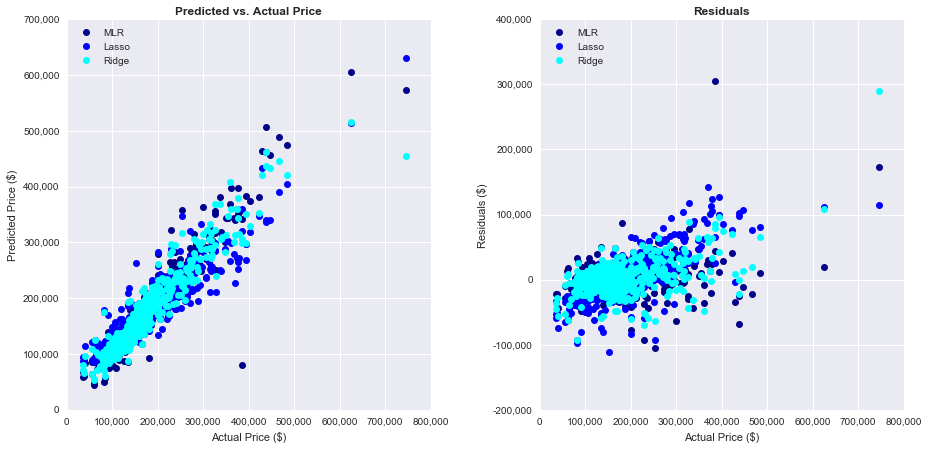

In [78]:
#residuals with log price models (in original scale)
MLRresiduals2 = y_test - np.exp(MLR_predict2)
lassoResiduals2 = y_test - np.exp(lasso_predict2)
ridgeResiduals2 = y_test - np.exp(ridge_predict2)

# Plot residuals
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,np.exp(MLR_predict2),"o",label='MLR',color='darkblue')
ax1.plot(y_test,np.exp(lasso_predict2),"o",label='Lasso',color='blue')
ax1.plot(y_test,np.exp(ridge_predict2),"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLRresiduals2,"o",label='MLR',color='darkblue')
ax2.plot(y_test,lassoResiduals2,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals2,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [79]:
# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_scaler = StandardScaler()
Y_scaled = ravel(y_scaler.fit_transform(y_train.reshape(-1, 1)))
Y_test_scaled = ravel(y_scaler.transform(y_test.reshape(-1, 1)))

C:\Users\Vishwa\Anaconda2\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [80]:
# Run MLP using different hidden layer sizes
sizes = [(20,),(50,),(100,),(150,),(200,),(250,),(300,)]
RMSEs = []
for size in sizes:
    MLP = MLPRegressor(hidden_layer_sizes = size,activation='tanh',solver='sgd',learning_rate='constant',random_state=42,\
                       batch_size=40,learning_rate_init=0.001)
    model_MLP = MLP.fit(X_scaled,Y_scaled)
    MLP_predict = model_MLP.predict(X_test_scaled)
    MLP_RMSE= sqrt(mean_squared_error(y_test, y_scaler.inverse_transform(MLP_predict)))
    RMSEs.append(MLP_RMSE)

In [81]:
# Choosing hidden layer size with best RMSE
MLP = MLPRegressor(hidden_layer_sizes = sizes[np.argmin(RMSEs)],activation='tanh',solver='sgd',learning_rate='constant',random_state=42,\
                   batch_size=40,learning_rate_init=0.001)
model_MLP = MLP.fit(X_scaled,Y_scaled)
MLP_predict = model_MLP.predict(X_test_scaled)
MLP_RMSE = sqrt(mean_squared_error(y_test, y_scaler.inverse_transform(MLP_predict)))
print "MLP RMSE:",MLP_RMSE

MLPresiduals = y_test - y_scaler.inverse_transform(MLP_predict)

MLP RMSE: 36015.4509214


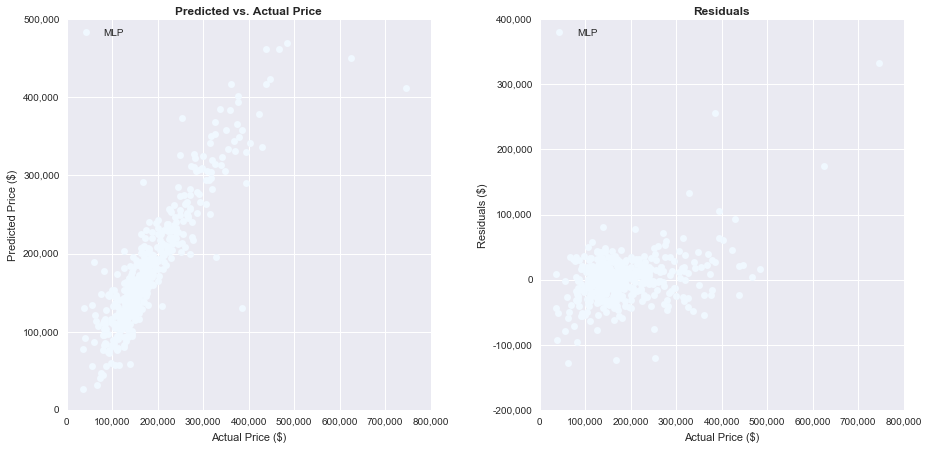

In [82]:
# Plot residuals
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,y_scaler.inverse_transform(MLP_predict),"o",label='MLP',color='aliceblue')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLPresiduals, "o",label='MLP',color='aliceblue')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [83]:
# Try Linear Regression, Lasso, and Ridge with scaled X data

#Linear Regression
MLR =LinearRegression(fit_intercept=False)
model_MLR1 = MLR.fit(X_scaled,y_train)
MLR_predict1 = model_MLR1.predict(X_test_scaled)
MLR_RMSE1= sqrt(mean_squared_error(y_test, MLR_predict1))
print "MLR RMSE:",MLR_RMSE1

#get best λ with LassoCV
lasso_cv1 = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv1 = lasso_cv1.fit(X_scaled,ravel(y_train))
print "Lasso CV best λ:",model_cv1.alpha_
lasso_predict1= model_cv1.predict(X_test_scaled)
lasso_RMSE1= sqrt(mean_squared_error(y_test, lasso_predict1))
print "Lasso RMSE:",lasso_RMSE1

#get best λ with RidgeCV
ridge_cv1 = RidgeCV(cv=10)
ridge_model_cv1 = ridge_cv1.fit(X_scaled,ravel(y_train))
print "Ridge CV best λ:",ridge_model_cv1.alpha_
ridge_predict1= ridge_model_cv1.predict(X_test_scaled)
ridge_RMSE1= sqrt(mean_squared_error(y_test, ridge_predict1))
print "Ridge RMSE:",ridge_RMSE1

MLR RMSE: 1.56758896303e+19
Lasso CV best λ: 1695.52642749
Lasso RMSE: 29925.6396206
Ridge CV best λ: 10.0
Ridge RMSE: 34043.6717917


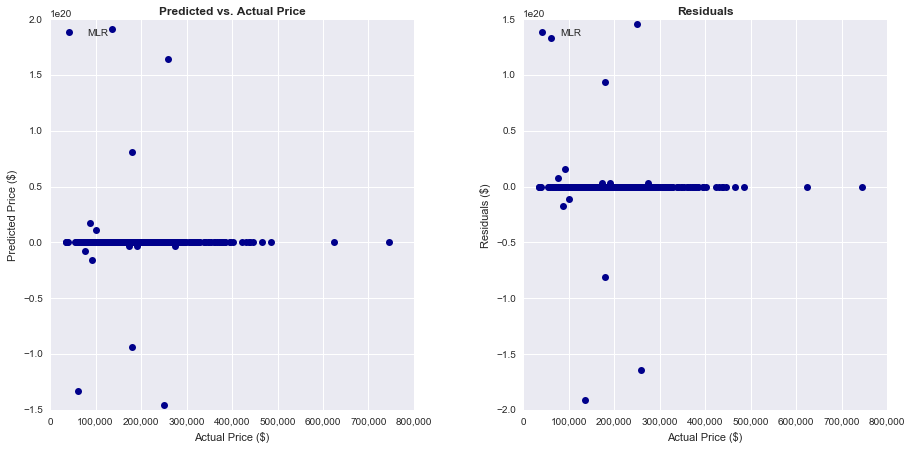

In [84]:
# Based on RMSE, it appears as though MLR may have challenges predicting this data
# For example, the linear regression problem could be under-determined 
#  (where the number of linearly independent rows of the training matrix 
#    is less than its number of linearly independent columns),
#  resulting in erroneous predictions

# Graph to see
MLRresiduals1 = y_test - MLR_predict1
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,MLR_predict1,"o",label='MLR',color='darkblue')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLRresiduals1, "o",label='MLR',color='darkblue')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

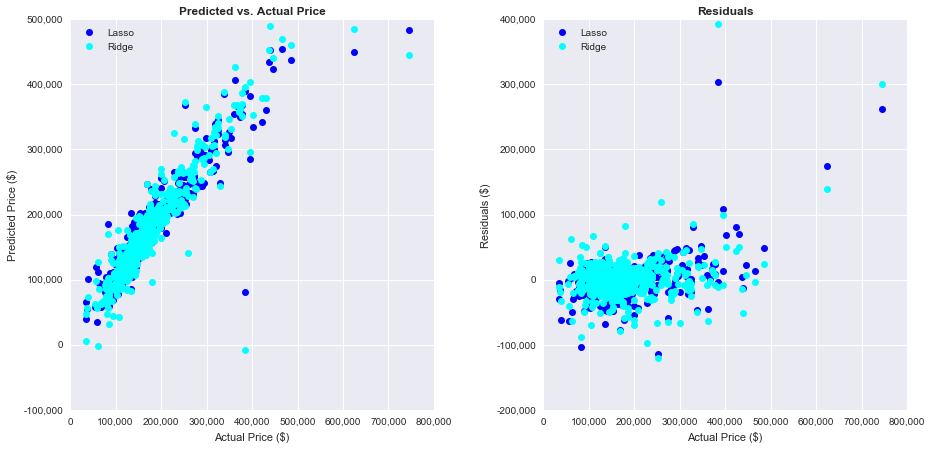

In [85]:
# Plot Lasso and Ridge
lassoResiduals1 = y_test - lasso_predict1
ridgeResiduals1 = y_test - ridge_predict1

fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,lasso_predict1,"o",label='Lasso',color='blue')
ax1.plot(y_test,ridge_predict1,"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,lassoResiduals1,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals1,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [86]:
# Try fitting on scaled data and log SalePrice for Lasso and Ridge
#get best λ with LassoCV
lasso_cv3 = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv3 = lasso_cv3.fit(X_scaled,ravel(log_y_train))
print "Lasso CV best λ:",model_cv3.alpha_
lasso_predict3= model_cv3.predict(X_test_scaled)
lasso_RMSE3 = sqrt(mean_squared_error(y_test, np.exp(lasso_predict3)))
print "Lasso RMSE:",lasso_RMSE3

#get best λ with RidgeCV
ridge_cv3 = RidgeCV(cv=10)
ridge_model_cv3 = ridge_cv3.fit(X_scaled,ravel(log_y_train))
print "Ridge CV best λ:",ridge_model_cv3.alpha_
ridge_predict3= ridge_model_cv3.predict(X_test_scaled)
ridge_RMSE3 = sqrt(mean_squared_error(y_test, np.exp(ridge_predict3)))
print "Ridge RMSE:",ridge_RMSE3

Lasso CV best λ: 0.00617476647261
Lasso RMSE: 23872.9408725
Ridge CV best λ: 10.0
Ridge RMSE: 26622.3843697


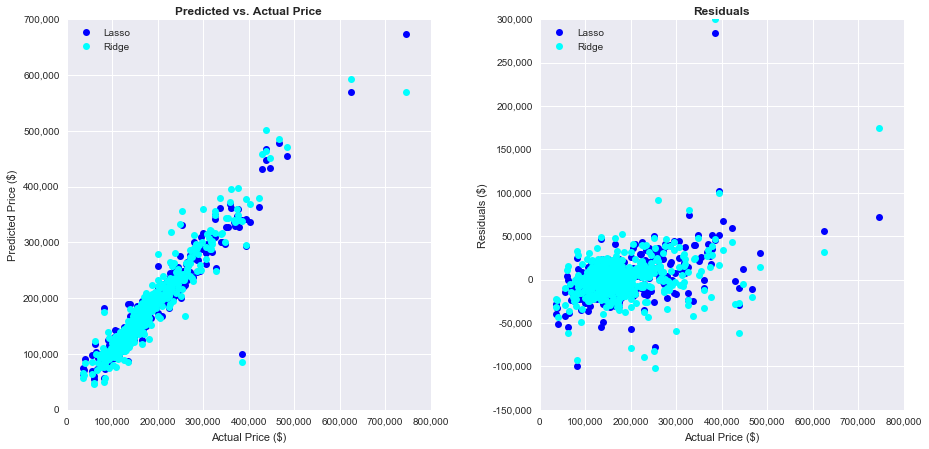

In [107]:
# Plot Lasso and Ridge results for scaled X data / log SalePrice
lassoResiduals3 = y_test - np.exp(lasso_predict3)
ridgeResiduals3 = y_test - np.exp(ridge_predict3)

fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,np.exp(lasso_predict3),"o",label='Lasso',color='blue')
ax1.plot(y_test,np.exp(ridge_predict3),"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,lassoResiduals3,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals3,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

### SVR

In [117]:
best = SVR(kernel='linear', C=10)
best.fit(X_train,y_train)
predictions=best.predict(X_test)
np.sqrt(mean_squared_error(y_test,predictions))

35094.699875423103

In [118]:
SVR_mod = SVR(kernel='linear', C=10)
SVR_mod.fit(X_scaled,y_train)
predictions1=SVR_mod.predict(X_test_scaled)
np.sqrt(mean_squared_error(y_test,predictions1))

43288.944140941188

In [ ]:
SVR_mod2 = SVR(kernel='linear', C=10)
SVR_mod2.fit(X_train,ravel(log_y_train))
predictions3=SVR_mod2.predict(X_test)
np.sqrt(mean_squared_error(y_test,np.exp(predictions3)))

In [125]:
SVR_mod1 = SVR(kernel='linear', C=10)
SVR_mod1.fit(X_scaled,ravel(log_y_train))
predictions2=SVR_mod1.predict(X_test_scaled)
np.sqrt(mean_squared_error(y_test,np.exp(predictions2)))

27686.677793698218

### SGD Regressor

In [ ]:
parameters = {'loss': ['squared_loss', 'huber'],
             'penalty': ['l1','l2'],
              'learning_rate': ['optimal','invscaling','constant']}
accuracy=make_scorer(mean_squared_error, greater_is_better=False)
clf2 = GridSearchCV(SGDRegressor(random_state=42), parameters, cv=5,scoring=accuracy)
clf2.fit(X_train, y_train)

In [ ]:
print clf2.best_params_
print clf2.best_score_

In [ ]:
best2 = SGDRegressor(loss='huber', penalty='l2',random_state=42)
best2.fit(X_train, y_train)
pred = best2.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

## Clustering

In [88]:
# Consolidate train data for clustering purposes
X_train_cluster = X_train.copy()
train_data_cluster = X_train_cluster.copy()
train_data_cluster['SalePrice'] = y_train
# Consolidate train data for graphing purposes
train_data = train_data_cluster.copy()
# train_data['Id'] = X_train['Id']

In [89]:
# Fit model with 5 clusters
KMmodel_5 = KMeans(n_clusters=5, random_state=1)
KMfit_5 = KMmodel_5.fit(train_data_cluster)

In [90]:
# Fit model with 5 clusters on X variables
KMmodel_5x = KMeans(n_clusters=5, random_state=1)
KMfit_5x = KMmodel_5x.fit(X_train_cluster)

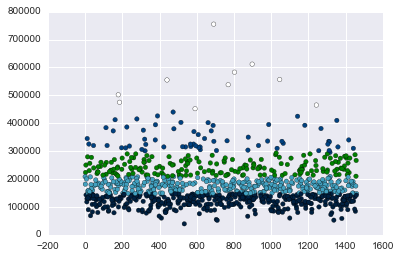

In [106]:
# Check for delineation across home prices purely based on cluster when price is included
scatter(train_data.index,train_data['SalePrice'],c=KMfit_5.labels_, cmap='ocean')


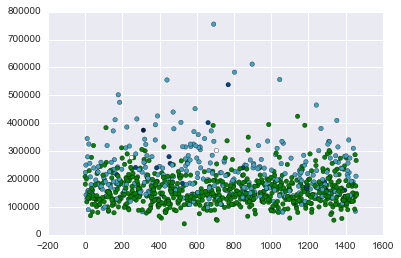

In [94]:
# Check for delineation across home prices purely based on cluster when price is excluded
scatter(train_data.index,train_data['SalePrice'],c=KMfit_5x.labels_, cmap='ocean')

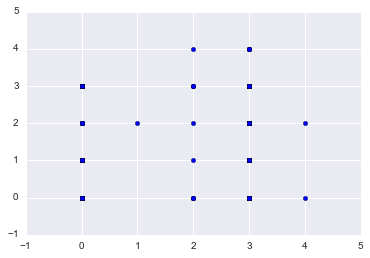

In [36]:
# Compare labels
scatter(KMfit_5x.labels_,KMfit_5.labels_)

In [37]:
# Get correlation of each column with both labels
correlation_dict={}
for column in train_data.columns.values:
    xcor=corrcoef(train_data[column],KMfit_5x.labels_)[0][1]
    totcor=corrcoef(train_data[column],KMfit_5.labels_)[0][1]
    correlation_dict[column]=[xcor,totcor]

In [38]:
# Put correlations into a dataframe
col1=correlation_dict.keys()
col2=[val[0] for val in correlation_dict.values()]
col3=[val[1] for val in correlation_dict.values()]
correlation_df=pd.DataFrame({'1_Column':col1,'2_X Corr':col2,'3_All Corr':col3})
correlation_df.head()

,1_Column,2_X Corr,3_All Corr
0,BsmtFinType2_ALQ,0.004170,0.034801
1,Condition2_Artery,-0.032733,-0.022887
2,SaleCondition_AdjLand,-0.032733,-0.022887
3,Exterior1st_AsbShng,-0.064986,-0.028130
4,PavedDrive_nan,NaN,NaN


In [41]:
# View 'best predictors' through sale price for correlation using all variables
bestpredictor_df=correlation_df.sort_values('3_All Corr',ascending=False).copy()
bestpredictor_df=bestpredictor_df.reset_index()
bestpredictor_df=bestpredictor_df.drop('index',1)
# All predictors up through saleprice
bestpredictor_df[:27]

,1_Column,2_X Corr,3_All Corr
0,HalfBath,0.147388,0.144541
1,Neighborhood_Gilbert,0.069268,0.140498
2,CentralAir_Y,0.104324,0.119619
3,ExterQual_Ex,0.135271,0.118435
4,MSSubClass_SPLIT OR MULTI-LEVEL,0.032753,0.116834
5,GarageType_Attchd,0.144481,0.112187
6,HouseStyle_SLvl,0.027569,0.110240
7,GarageQual_TA,0.122808,0.108774
8,Neighborhood_NWAmes,0.106843,0.107830
9,FullBath,0.206710,0.100977


In [42]:
# Create new X matrix with just these columns
X_cluster = X_train.ix[:,:1].copy()
for colname in bestpredictor_df['1_Column'][:26]:
    X_cluster[colname]=X_train[colname]
X_cluster=X_cluster.drop('Id',1)
X_cluster.head()

,HalfBath,Neighborhood_Gilbert,CentralAir_Y,ExterQual_Ex,MSSubClass_SPLIT OR MULTI-LEVEL,GarageType_Attchd,HouseStyle_SLvl,GarageQual_TA,Neighborhood_NWAmes,FullBath,...,FireplaceQu_TA,Heating_GasA,Alley_Pave,MSZoning_RL,ScreenPorch,LotConfig_FR2,Electrical_SBrkr,SaleType_New,Fireplaces,HouseStyle_2.5Fin
355,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2,...,0.0,1.0,0.0,1.0,0,0.0,1.0,0.0,0,0.0
547,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,...,0.0,1.0,0.0,1.0,0,0.0,1.0,0.0,0,0.0
1293,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,2,...,1.0,1.0,0.0,1.0,259,0.0,1.0,0.0,1,0.0
452,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2,...,0.0,1.0,0.0,1.0,0,0.0,1.0,0.0,0,0.0
1292,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2,...,0.0,1.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0


In [43]:
# Fit model with 5 clusters on X cluster data
KMmodel_5xc = KMeans(n_clusters=5, random_state=1)
KMfit_5xc = KMmodel_5xc.fit(X_cluster)

In [44]:
# Prepare cluster data for graphing
cluster_data=X_cluster.copy()
cluster_data['Id']=X_train['Id']
cluster_data['SalePrice']=y_train

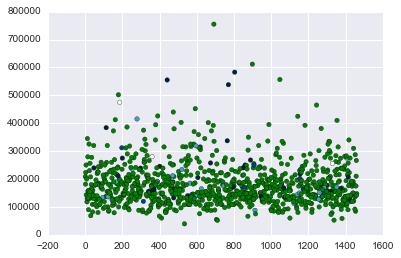

In [64]:
# Check for delineation across home prices purely based on cluster using cluster data when price is excluded
scatter(cluster_data['Id'],cluster_data['SalePrice'],c=KMfit_5xc.labels_, cmap='ocean')

In [46]:
# Get top and bottom indicators for each cluster
# where 'top' is biggest number (i.e., largest and/or most postive)
# and 'bottome' is smallest number (i.e., smallest and/or most negative)
keyindicators_dict={}
centercounter=0
for center in KMfit_5.cluster_centers_:
    label=list(set(KMfit_5.labels_))[centercounter]
    top5indices=np.argpartition(center,-5)[-5:]
    top5=list(train_data.columns.values[top5indices])
    top10indices=np.argpartition(center,-10)[-10:]
    top10=list(train_data.columns.values[top10indices])
    bottom5indices=np.argpartition(center,5)[:5]
    bottom5=list(train_data.columns.values[bottom5indices])
    bottom10indices=np.argpartition(center,10)[:10]
    bottom10=list(train_data.columns.values[bottom10indices])
    keyindicators_dict[label]=[top5,top10,bottom5,bottom10]
    centercounter+=1

In [47]:
# Get all indicators in top10s
top10lists=[val[1] for val in keyindicators_dict.values()]
uniquetop10=list(set([j for i in top10lists for j in i]))
uniquetop10

['BsmtUnfSF',
 '1stFlrSF',
 'YrSold',
 '2ndFlrSF',
 'LotArea',
 'TotalBsmtSF',
 'SalePrice',
 'GarageArea',
 'GrLivArea',
 'BsmtFinSF1']

In [48]:
# Get all indicators in bottom10s
bottom10lists=[val[3] for val in keyindicators_dict.values()]
uniquebottom10=list(set([j for i in bottom10lists for j in i]))
uniquebottom10

['ExterQual_TA',
 'RoofMatl_nan',
 'Heating_GasW',
 'Neighborhood_Blmngtn',
 'BldgType_TwnhsE',
 'Neighborhood_MeadowV',
 'HeatingQC_nan',
 'Neighborhood_nan',
 'MoSold_May',
 'Neighborhood_SWISU',
 'Neighborhood_BrDale',
 'MiscVal',
 'MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
 'Alley_Grvl',
 'RoofStyle_nan',
 'Neighborhood_Gilbert',
 'MSSubClass_1-STORY 1945 & OLDER',
 'Exterior2nd_MetalSd',
 'CentralAir_N',
 'Neighborhood_NoRidge',
 'Electrical_FuseA',
 'Condition1_Feedr',
 'Electrical_FuseF',
 'Neighborhood_StoneBr',
 'BsmtCond_Fa',
 'HouseStyle_1.5Unf',
 'BldgType_Twnhs',
 'Fence_GdWo',
 'Neighborhood_NWAmes',
 'HeatingQC_TA',
 'LandSlope_nan',
 'LandContour_Bnk',
 'SaleCondition_Abnorml',
 'RoofMatl_Metal',
 'ExterCond_Fa',
 'BsmtExposure_nan',
 'Exterior1st_MetalSd',
 'MiscFeature_TenC',
 'FireplaceQu_Po',
 'Street_nan',
 'BsmtQual_Fa',
 'Foundation_Stone',
 'HeatingQC_Po',
 'Utilities_nan',
 'PavedDrive_N',
 'Functional_Maj2',
 'LotShape_IR3']

In [49]:
# Design matrix of top10
X_top10 = X_train.ix[:,:1].copy()
for colname in uniquetop10:
    try:
        X_top10[colname]=X_train[colname]
    except:
        pass # SalePrice
X_top10=X_top10.drop('Id',1)
X_top10.head()

,BsmtUnfSF,1stFlrSF,YrSold,2ndFlrSF,LotArea,TotalBsmtSF,GarageArea,GrLivArea,BsmtFinSF1
355,322,1200,2007,0,11249,1200,521,1200,334
547,149,768,2007,0,7244,768,624,768,619
1293,638,832,2006,832,10140,832,528,1664,194
452,130,888,2007,868,9303,872,422,1756,742
1292,994,1378,2009,994,6600,994,432,2372,0


In [50]:
# Fit model with 5 clusters on top10
KMmodel_5xt10 = KMeans(n_clusters=5, random_state=1)
KMfit_5xt10 = KMmodel_5xt10.fit(X_top10)

In [51]:
# Prepare cluster data for graphing
top10_data=X_top10.copy()
top10_data['Id']=X_train['Id']
top10_data['SalePrice']=y_train

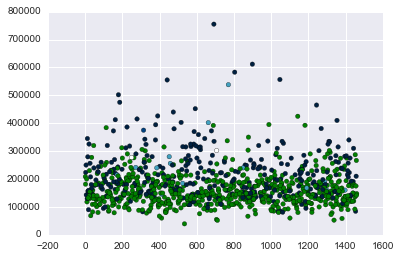

In [65]:
# Check for delineation across home prices purely based on cluster using cluster data when price is excluded
scatter(top10_data['Id'],top10_data['SalePrice'],c=KMfit_5xt10.labels_, cmap='ocean')

In [54]:
# Let's run models just to test...need test data first
X_top10_test = X_test.ix[:,:1].copy()
for colname in uniquetop10:
    try:
        X_top10_test[colname]=X_test[colname]
    except:
        pass # SalePrice
X_top10_test=X_top10_test.drop('Id',1)
X_top10_test.head()

,BsmtUnfSF,1stFlrSF,YrSold,2ndFlrSF,LotArea,TotalBsmtSF,GarageArea,GrLivArea,BsmtFinSF1
258,602,963,2008,829,12435,963,564,1792,361
267,342,1052,2008,720,8400,720,240,2192,378
288,432,900,2010,0,9819,882,280,900,450
649,0,630,2007,0,1936,630,0,630,131
1233,188,1188,2010,0,12160,1188,531,1188,1000


In [55]:
# Fit model with 5 clusters on top10 for test data
KMmodel_5xt10test = KMeans(n_clusters=5, random_state=1)
KMfit_5xt10test = KMmodel_5xt10test.fit(X_top10_test)

In [56]:
X_top10['Cluster']=KMfit_5xt10.labels_
X_top10_test['Cluster']=KMfit_5xt10test.labels_

In [57]:
# Run models
#Linear Regression
MLR =LinearRegression()
model_MLR = MLR.fit(X_top10,y_train)
MLR_predict = model_MLR.predict(X_top10_test)
MLR_RMSE= sqrt(mean_squared_error(y_test, MLR_predict))
print "MLR RMSE:",MLR_RMSE

#get best λ with LassoCV
lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv = lasso_cv.fit(X_top10,ravel(y_train))
print "Lasso CV best λ:",model_cv.alpha_

#Lasso
lasso= Lasso(alpha=model_cv.alpha_)
model_lasso= lasso.fit(X_top10,y_train)
lasso_predict= model_lasso.predict(X_top10_test)
lasso_RMSE= sqrt(mean_squared_error(y_test, lasso_predict))
print "Lasso RMSE:",lasso_RMSE

#get best λ with RidgeCV
ridge_cv = RidgeCV(cv=10)
ridge_model_cv = ridge_cv.fit(X_top10,ravel(y_train))
print "Ridge CV best λ:",ridge_model_cv.alpha_

#Ridge
ridge= Ridge(alpha=ridge_model_cv.alpha_)
model_ridge= ridge.fit(X_top10,y_train)
ridge_predict= model_ridge.predict(X_top10_test)
ridge_RMSE= sqrt(mean_squared_error(y_test, ridge_predict))
print "Ridge RMSE:",ridge_RMSE

MLR RMSE: 44056.4050299
Lasso CV best λ: 735054.544487
Lasso RMSE: 44426.7997956
Ridge CV best λ: 10.0
Ridge RMSE: 43964.5474218


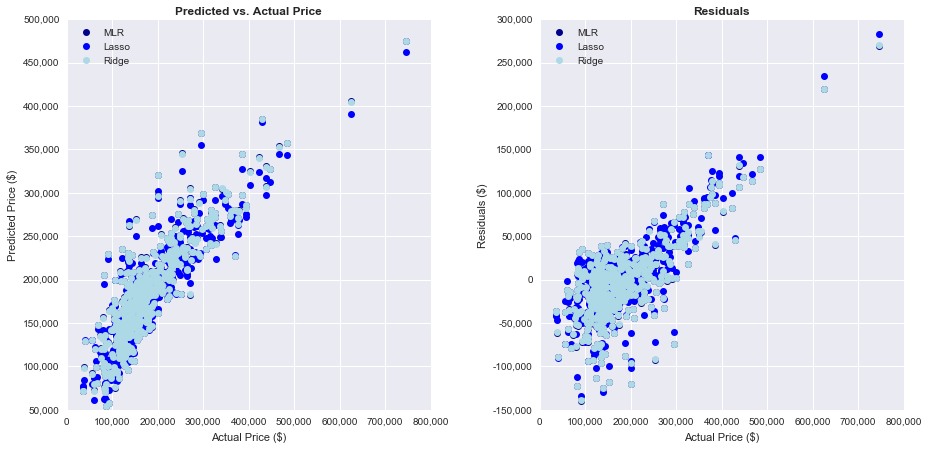

In [58]:
# Not great...
# But let's see if the errors are in different places...

MLRresiduals = y_test - MLR_predict
lassoResiduals = y_test - lasso_predict
ridgeResiduals = y_test - ridge_predict

# Plot
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,MLR_predict,"o",label='MLR', color='darkblue')
ax1.plot(y_test,lasso_predict,"o",label='Lasso',color='blue')
ax1.plot(y_test,ridge_predict,"o",label='Ridge',color='lightblue')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLRresiduals,"o",label='MLR',color='darkblue')
ax2.plot(y_test,lassoResiduals,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals,"o",label='Ridge',color='lightblue')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [14]:
from collections import Counter
Counter(list(KMfit_5x.labels_))

Counter({0: 640, 1: 1, 2: 14, 3: 321, 4: 2})

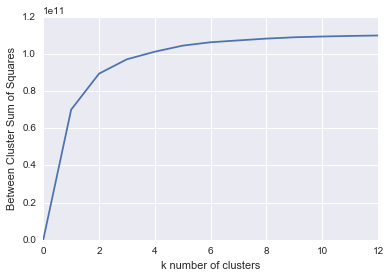

In [95]:
from scipy.spatial.distance import cdist,pdist

#cross-validating to find best number of clusters
k_range = range(1,14)
k_means_var = [KMeans(n_clusters=k).fit(X_train_cluster) for k in k_range]
centroids = [c.cluster_centers_ for c in k_means_var]
euclid = [cdist(X_train_cluster,cent,'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in euclid]

#within cluster ss
wcss = [sum(d**2) for d in dist]

#total cluster ss
tss = sum(pdist(X_train_cluster)**2)/X_train_cluster.shape[0]

#between cluster ss
bss = tss - wcss

#elbow curve to identify best k (number of clusters)
plt.plot(bss)
plt.xlabel('k number of clusters')
plt.ylabel('Between Cluster Sum of Squares')


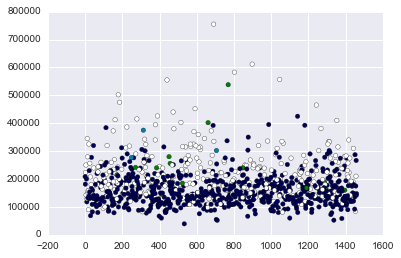

In [96]:
# Fit model with 5 clusters on X variables
KMmodel_4x = KMeans(n_clusters=4, random_state=1)
KModel_fit= KMmodel_4x.fit_predict(X_train_cluster)
scatter(train_data.index,train_data['SalePrice'],c=KModel_fit, cmap='ocean')


In [97]:
Counter(list(KModel_fit))
# len(X_train_cluster)

Counter({0: 14, 1: 640, 2: 3, 3: 321})

In [98]:
X_train_cluster= X_train_cluster.reset_index(drop=True)
X_train_cluster['cluster'] = pd.Series(KModel_fit)

In [99]:
X_test_cluster = X_test.copy()
X_test_cluster= X_test_cluster.reset_index(drop=True)
KMmodel_4x_pred = KMmodel_4x.predict(X_test_cluster)
X_test_cluster['cluster'] = pd.Series(KMmodel_4x_pred)

In [100]:
pd.Series(KMmodel_4x_pred).value_counts()

1    312
3    165
0      4
2      1
dtype: int64

In [101]:
# Run models
#Linear Regression
MLR =LinearRegression()
model_MLR = MLR.fit(X_train_cluster,y_train)
MLR_predict = model_MLR.predict(X_test_cluster)
MLR_RMSE= sqrt(mean_squared_error(y_test, MLR_predict))
print "MLR RMSE:",MLR_RMSE

#get best λ with LassoCV
lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv = lasso_cv.fit(X_train_cluster,ravel(y_train))
print "Lasso CV best λ:",model_cv.alpha_
lasso_predict= model_cv.predict(X_test_cluster)
lasso_RMSE= sqrt(mean_squared_error(y_test, lasso_predict))
print "Lasso RMSE:",lasso_RMSE

#get best λ with RidgeCV
ridge_cv = RidgeCV(cv=10)
ridge_model_cv = ridge_cv.fit(X_train_cluster,ravel(y_train))
print "Ridge CV best λ:",ridge_model_cv.alpha_
ridge_predict= ridge_model_cv.predict(X_test_cluster)
ridge_RMSE= sqrt(mean_squared_error(y_test, ridge_predict))
print "Ridge RMSE:",ridge_RMSE

MLR RMSE: 35033.3766393
Lasso CV best λ: 224475.036998
Lasso RMSE: 39996.0347001
Ridge CV best λ: 10.0
Ridge RMSE: 30057.4078749


Decision Trees

In [10]:
# Create and fit the model
model_tree1 = DecisionTreeClassifier(random_state = 1)
model_tree1.fit(X_train, y_train)

# Predict on the test set
p_tree1 = model_tree1.predict(X_test)

# Calculate RMSE of the model
residuals = p_tree1 - y_test
MSE = (residuals**2).mean()
RMSE = math.sqrt(MSE)

print "RMSE for Classification Tree is:", round(RMSE,4)

RMSE for Classification Tree is: 59542.5438


In [11]:
# Create and fit the model
model_tree2 = DecisionTreeRegressor(random_state = 1)
model_tree2.fit(X_train, y_train)

# Predict on the test set
p_tree2 = model_tree2.predict(X_test)

# Calculate RMSE of the model
residuals = p_tree2 - y_test
MSE = (residuals**2).mean()
RMSE = math.sqrt(MSE)

print "RMSE for Regression Tree is:", round(RMSE,4)

RMSE for Regression Tree is: 42057.2156


In [12]:
# Feature importances from Model 1
imp_tree1 = pd.Series(model_tree1.feature_importances_,X_train.columns.values)
print imp_tree1.sort_values(ascending = False)[:10]

# Feature importances from Model 2
imp_tree2 = pd.Series(model_tree2.feature_importances_,X_train.columns.values)
print imp_tree2.sort_values(ascending = False)[:10]

GarageArea     0.036020
TotalBsmtSF    0.032599
LotFrontage    0.031219
AgeRem         0.029763
1stFlrSF       0.026947
YrSold         0.025527
GrLivArea      0.025268
BsmtFinSF1     0.023452
BsmtUnfSF      0.020412
MasVnrArea     0.019777
dtype: float64
OverallQual            0.614102
GrLivArea              0.084007
BsmtFinSF1             0.047267
TotalBsmtSF            0.028029
Exterior1st_HdBoard    0.024879
LotArea                0.018646
BsmtExposure_Gd        0.018032
GarageArea             0.017976
WoodDeckSF             0.017917
LotFrontage            0.016860
dtype: float64


Random Forest

In [13]:
# Create parameters for model
n_trees = 10
max_depth = 10

# Create and fit the model
model_rf1 = RandomForestRegressor(n_estimators = n_trees)
model_rf1.fit(X_train, y_train)

# Predict on the test set
p_rf1 = model_rf1.predict(X_test)

# Calculate RMSE of the model
residuals = p_rf1 - y_test
MSE = (residuals**2).mean()
RMSE = math.sqrt(MSE)

print "RMSE for Random Forest is:", round(RMSE,4)

RMSE for Random Forest is: 30607.3164


In [16]:
# Cross validate RF model
# Set parameter dictionary to search through
params = {'n_estimators':[10,100,500, 1000], 'max_depth':[5,10,20]}

# Create model and fit best parameters
model_rf2 = RandomForestRegressor()
model_rf2_GS = GridSearchCV(model_rf2, params)

In [17]:
# Avoid running Grid Search after finding best params
# Comment this line out if need to re-run Grid Search
model_rf2_GS = RandomForestRegressor(n_estimators=100, max_depth=20)

model_rf2_GS.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [18]:
# Save best estimates to avoid re-running grid search
#model_rf2_GS.best_estimator_

In [19]:
# Make predictions on Grid search optimized RF model
p_rf2 = model_rf2_GS.predict(X_test)

# Calculate RMSE of the model
residuals = p_rf2 - y_test
MSE = (residuals**2).mean()
RMSE = math.sqrt(MSE)

print "RMSE for Random Forest is:", round(RMSE,4)

RMSE for Random Forest is: 26991.4519


Gradient Boosting

In [20]:
# Create Gradient Boosting Model
model_gb1 = GradientBoostingRegressor()

# Create parameter dictionary for GridSearchCV
params = {'n_estimators':(5,10,50,100,500,1000),'learning_rate':(0.01, 0.05, 0.1, 0.2)}

#Create Grid Search Model
model_gb1_GS = GridSearchCV(model_gb1,params)

In [22]:
# Avoid running Grid Search after finding best Params
# Comment this line out if need to re-run Grid Search
model_gb1_GS = GradientBoostingRegressor(n_estimators=100,learning_rate=0.1)

model_gb1_GS.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [23]:
# Save best estimates to avoid re-running grid search
#model_gb1_GS.best_estimator_

In [24]:
# Make predictions on Grid search optimized Gradient Boostin model
p_gb1 = model_gb1_GS.predict(X_test)

# Calculate RMSE of the model
residuals = p_gb1 - y_test
MSE = (residuals**2).mean()
RMSE = math.sqrt(MSE)

print "RMSE for Random Forest is:", round(RMSE,4)

RMSE for Random Forest is: 23785.1015
